In [4]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm

# Téléchargement des ressources NLTK
print("Téléchargement des ressources NLTK...")
nltk.download('punkt')
nltk.download('stopwords')

# Fonction de nettoyage améliorée pour éliminer tous les caractères spéciaux
def clean_text(text):
    if not isinstance(text, str) or pd.isna(text):
        return ""

    text = str(text)

    # Suppression des mentions, hashtags, URLs et autres caractères spéciaux
    text = re.sub(r"@\w+", "", text)  # Supprime les mentions (@user)
    text = re.sub(r"#\w+", "", text)  # Supprime les hashtags (#topic)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)  # Supprime les URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)  # Ne garde que les lettres, chiffres et espaces

    # Supprime les espaces multiples et les espaces en début/fin
    return re.sub(r"\s+", " ", text).strip()

# Fonction de tokenization simple
def simple_tokenize(text):
    if not text or not isinstance(text, str):
        return []

    # Tokenization simple par espaces
    return text.lower().split()

# Prétraitement complet
def preprocess_text(text, lang='english'):
    # Nettoyage du texte
    text = clean_text(text)
    if not text:
        return ""

    # Tokenization
    tokens = simple_tokenize(text)
    if not tokens:
        return ""

    try:
        # Stemming et suppression des stopwords
        stemmer = SnowballStemmer(lang)
        stop_words = set(stopwords.words(lang))

        processed = [
            stemmer.stem(token)
            for token in tokens
            if token.isalpha() and token not in stop_words
        ]
        return " ".join(processed) if processed else ""
    except Exception as e:
        print(f"Erreur de traitement: {str(e)}")
        return ""

# Chargement des données
print("Chargement du dataset...")
try:
    df = pd.read_csv('training.1600000.processed.noemoticon.csv',
                    encoding='latin1',
                    header=None,
                    names=['target', 'ids', 'date', 'flag', 'user', 'text'],
                    dtype={'target': str, 'ids': str, 'text': str},
                    on_bad_lines='skip')

    print(f"Dataset chargé avec {len(df)} lignes")

    # Application du prétraitement avec barre de progression
    print("Traitement des textes...")
    tqdm.pandas(desc="Traitement des textes")
    df['processed'] = df['text'].progress_apply(lambda x: preprocess_text(x, 'english'))

    # Filtrer pour ne garder que les tweets valides (texte traité non vide)
    valid_df = df[df['processed'].str.len() > 0].copy()

    print("\nRésultats:")
    print(f"Textes traités au total: {len(df)}")
    print(f"Textes valides conservés: {len(valid_df)}")

    # Afficher quelques exemples
    print("\nExemples:")
    print(valid_df[['text', 'processed']].sample(3))

    # Sauvegarder le dataframe filtré
    valid_df.to_csv('valid_processed_tweets.csv', index=False)
    print("\nDataframe filtré sauvegardé dans 'valid_processed_tweets.csv'")

except Exception as e:
    print(f"Erreur lors du chargement ou du traitement du dataset: {str(e)}")


Téléchargement des ressources NLTK...
Chargement du dataset...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset chargé avec 1048573 lignes
Traitement des textes...


Traitement des textes: 100%|██████████| 1048573/1048573 [04:47<00:00, 3650.18it/s]



Résultats:
Textes traités au total: 1048573
Textes valides conservés: 1043031

Exemples:
                                                     text  \
444475  @sarah_fn i knw the feeling,so fucked for tomo...   
486883  @DonDiva47 damn  quite unfortunate...where are...   
988171  @cosleia Am worried you're not getting my emai...   

                                                processed  
444475                  knw feel fuck tomorrow im sad lol  
486883     damn quit unfortun u kno prolli told forgotten  
988171  worri get email email yesterday request trip i...  

Dataframe filtré sauvegardé dans 'valid_processed_tweets.csv'


In [7]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# Chargement du dataset filtré
print("Chargement du dataset filtré...")
valid_df = pd.read_csv('valid_processed_tweets.csv')

# Vérification des valeurs uniques dans la colonne target
print("Valeurs uniques dans la colonne target:", valid_df['target'].unique())

# Assurez-vous que la colonne target est de type string
valid_df['target'] = valid_df['target'].astype(str)

# Créer des sous-ensembles pour chaque sentiment
positive_tweets = valid_df[valid_df['target'] == '4']['processed']
neutral_tweets = valid_df[valid_df['target'] == '2']['processed']
negative_tweets = valid_df[valid_df['target'] == '0']['processed']

print(f"Tweets positifs: {len(positive_tweets)}")
print(f"Tweets neutres: {len(neutral_tweets)}")
print(f"Tweets négatifs: {len(negative_tweets)}")

# Fonction pour extraire tous les mots uniques d'un ensemble de tweets
def extract_unique_words(texts):
    unique_words = set()
    for text in texts:
        if isinstance(text, str):
            words = text.split()
            unique_words.update(words)
    return unique_words

# Extraire les mots uniques pour chaque catégorie
print("Extraction des mots uniques par sentiment...")
positive_words = extract_unique_words(positive_tweets)
neutral_words = extract_unique_words(neutral_tweets)
negative_words = extract_unique_words(negative_tweets)

print(f"Mots uniques positifs: {len(positive_words)}")
print(f"Mots uniques neutres: {len(neutral_words)}")
print(f"Mots uniques négatifs: {len(negative_words)}")

# Fonction pour calculer le vecteur de caractéristiques d'un tweet
def calculate_feature_vector(text):
    if not isinstance(text, str) or not text:
        return [1, 0, 0, 0]  # Biais et zéros pour un texte vide

    words = text.split()
    if not words:
        return [1, 0, 0, 0]

    # Compter combien de mots du tweet appartiennent à chaque catégorie
    pos_count = sum(1 for word in words if word in positive_words)
    neu_count = sum(1 for word in words if word in neutral_words)
    neg_count = sum(1 for word in words if word in negative_words)

    return [1, pos_count, neu_count, neg_count]

# Appliquer la fonction à chaque tweet
print("Calcul des vecteurs de caractéristiques pour chaque tweet...")
tqdm.pandas(desc="Traitement des tweets")
valid_df['feature_vector'] = valid_df['processed'].progress_apply(calculate_feature_vector)

# Extraire les composantes du vecteur dans des colonnes séparées
valid_df['bias'] = valid_df['feature_vector'].apply(lambda x: x[0])
valid_df['positive_count'] = valid_df['feature_vector'].apply(lambda x: x[1])
valid_df['neutral_count'] = valid_df['feature_vector'].apply(lambda x: x[2])
valid_df['negative_count'] = valid_df['feature_vector'].apply(lambda x: x[3])

# Supprimer la colonne feature_vector (qui contient des listes)
valid_df = valid_df.drop('feature_vector', axis=1)

# Sauvegarder le DataFrame avec les vecteurs de caractéristiques
valid_df.to_csv('tweets_with_sentiment_counts.csv', index=False)
print("Dataset avec vecteurs de caractéristiques sauvegardé dans 'tweets_with_sentiment_counts.csv'")

# Créer un dataset compact avec seulement les vecteurs de caractéristiques
compact_df = valid_df[['target', 'bias', 'positive_count', 'neutral_count', 'negative_count']]
compact_df.to_csv('sentiment_count_vectors.csv', index=False)
print("Vecteurs de caractéristiques compacts sauvegardés dans 'sentiment_count_vectors.csv'")

# Afficher quelques exemples
print("\nExemples de tweets avec leurs vecteurs de caractéristiques:")
sample_df = valid_df[['text', 'processed', 'target', 'bias', 'positive_count', 'neutral_count', 'negative_count']].sample(5)
print(sample_df)

# Statistiques sur les comptages
print("\nStatistiques sur les comptages de mots par sentiment:")
stats_df = valid_df[['positive_count', 'neutral_count', 'negative_count']].describe()
print(stats_df)

Chargement du dataset filtré...


<ipython-input-7-cdcc165e2ad5>:8: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  valid_df = pd.read_csv('valid_processed_tweets.csv')


Valeurs uniques dans la colonne target: ['polarity of tweet\xa0' '0' 0 4]
Tweets positifs: 247140
Tweets neutres: 0
Tweets négatifs: 795890
Extraction des mots uniques par sentiment...
Mots uniques positifs: 69156
Mots uniques neutres: 0
Mots uniques négatifs: 129022
Calcul des vecteurs de caractéristiques pour chaque tweet...


Traitement des tweets: 100%|██████████| 1043031/1043031 [00:07<00:00, 133070.98it/s]


Dataset avec vecteurs de caractéristiques sauvegardé dans 'tweets_with_sentiment_counts.csv'
Vecteurs de caractéristiques compacts sauvegardés dans 'sentiment_count_vectors.csv'

Exemples de tweets avec leurs vecteurs de caractéristiques:
                                                     text  \
662240  Something in my house is causing an impromptu ...   
405656  @mintconspiracy mine can make toast but will n...   
41451   did i mention, I miss @gabrielleliorti  sorry ...   
648795                          I'm making some homework    
144361  @1queer1 Yes, let's work it out :-D. Having li...   

                                                processed target  bias  \
662240  someth hous caus impromptu sinus headach stuff...      0     1   
405656                               mine make toast danc      0     1   
41451       mention miss sorri vent noth work right clear      0     1   
648795                                      make homework      0     1   
144361  yes let work lit

                     target              ids                          date  \
0        polarity of tweet   id of the tweet             date of the tweet   
1                         0       1467810672  Mon Apr 06 22:19:49 PDT 2009   
2                         0       1467810917  Mon Apr 06 22:19:53 PDT 2009   
3                         0       1467811184  Mon Apr 06 22:19:57 PDT 2009   
4                         0       1467811193  Mon Apr 06 22:19:57 PDT 2009   
...                     ...              ...                           ...   
1043026                   4       1960186342  Fri May 29 07:33:44 PDT 2009   
1043027                   4       1960186409  Fri May 29 07:33:43 PDT 2009   
1043028                   4       1960186429  Fri May 29 07:33:44 PDT 2009   
1043029                   4       1960186445  Fri May 29 07:33:44 PDT 2009   
1043030                   4       1960186607  Fri May 29 07:33:45 PDT 2009   

             flag             user  \
0           query        

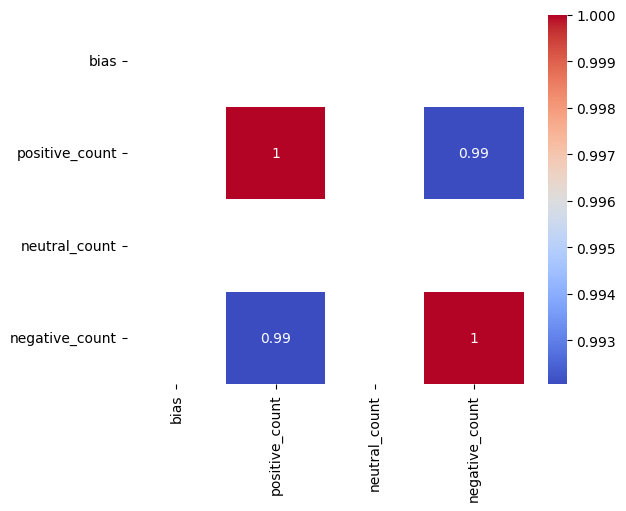

In [29]:
print(valid_df)
import seaborn as sns
import matplotlib.pyplot as plt
df9=valid_df.iloc[:,7:11]
df10=valid_df.iloc[:,0]
print(df10)
c19 = df9.corr()
c20=sns.heatmap(c19,annot=True,cmap='coolwarm')
plt.show()


[[159242  43886      1]
 [     0   5478      0]
 [     0      0      0]]


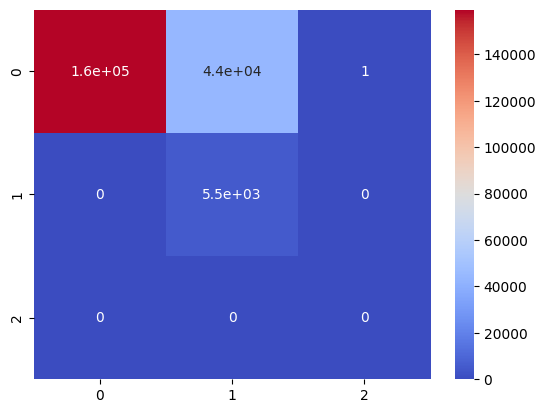

78.9618756801066 %


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df9, df10, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
model = LogisticRegression()
model.fit(X_train, y_train)
y_predict=model.predict(X_test)
print(confusion_matrix(y_predict,y_test))
c22=confusion_matrix(y_predict,y_test)
c23 = sns.heatmap(c22,annot=True,cmap='coolwarm')
plt.show()
accuracy=(c22[0,0]+c22[1,1])/(c22[0,0]+c22[1,1]+c22[0,1]+c22[1,0]+1)
c200=accuracy*100
print(c200,"%")



In [36]:
from sklearn.model_selection import cross_val_score
c000=cross_val_score(model,df9,df10,cv=10)
print(c000)
print(c000.mean())
print(c200.std())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


[0.78862747 0.78905688 0.78968007 0.78800226 0.78786804 0.78799268
 0.79006356 0.79166467 0.79084974 0.78848164]
0.789228700394549
0.0
